In [304]:
import numpy as np
import pandas as pd
import random
random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Introduction to Statistical Test Setup
***
We want to test the improvement on a binomial varaible (i.e. CTR):
* Current value: 16% 
* Target value: 17% (+1%, per business directions)

Below we state what this would look like from an experiment point of view and what to mind.

In [296]:
# metrics
p_control = 0.16 
p_treatment = 0.17

In [297]:
# run a binomial simulation
def simulateBinoms(control_p, treat_p, n, sz = 100000):
    control = np.random.binomial(n, control_p, size = sz)/n
    treatment = np.random.binomial(n, treat_p, size = sz)/n
    return control, treatment

### 1. Sample Size influence
***
How does the amount of users in our test affect the distribution?

In [343]:
n = 1000
control, treatment = simulateBinoms(control_p, treat_p, n, sz = 100000)

In [344]:
def bin_edges(control):
    edges = np.linspace(control.min(), control.max(), 50)
    labels = (edges + np.diff(edges).max()/2)[:-1]
    return edges, labels

In [365]:
def plotHist(ax, arr1, arr2, n = 0, binw = 0.003):
    ax.hist(arr1, bins = np.arange(arr1.min(), arr1.max(), binw), color = 'b', alpha = 0.4, label = 'p = {:.2f}'.format(arr1.mean()))
    ax.hist(arr2, bins = np.arange(arr2.min(), arr2.max(), binw), color = 'r', alpha = 0.4, label = 'p = {:.2f}'.format(arr2.mean()))
    ax.legend()
    if n!= 0:
        ax.set_title('n = {:,.0f}'.format(n))

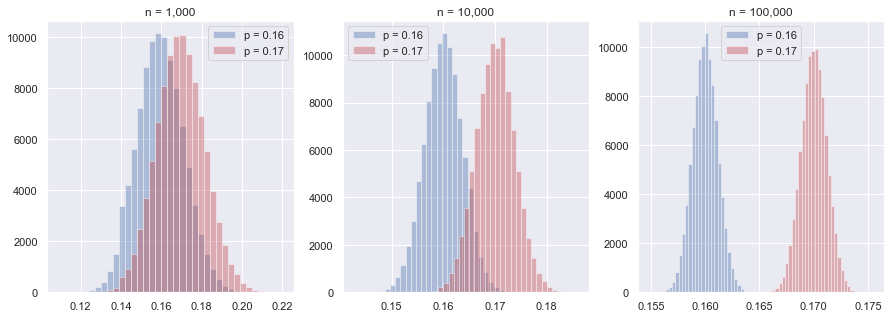

In [376]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))

n = 1000
control, treatment = simulateBinoms(control_p, treat_p, n)
plotHist(ax[0], control, treatment, n, binw = 0.003)

n = 10000
control, treatment = simulateBinoms(control_p, treat_p, n)
plotHist(ax[1], control, treatment, n, binw = 0.001)

n = 100000
control, treatment = simulateBinoms(control_p, treat_p, n)
plotHist(ax[2], control, treatment, n, binw = 0.0003)

plt.show()

#### Observations:
1. The distributions get increasingly more narrow when as number of users increase. This is expected, given the standard error for a binomial scales with the inverse of number of users: $SE = \sqrt{\frac{p(1-p)}{N}}$
2. As a result of this, the peaks move apart and can separate more. For our experiment, this means we increasingly more certain of the difference (improvement) of the new version.

### 2. Metrics
***
Source: https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

We wish to estimate the significance iof the new distribution vs. the old. To make this a nice comparison, we will use the mean as summary metric and look at the difference between means. We now can formulate our two hypotheses:
<center>$H_0: \mu_{treatment} - \mu_{control} \leq 0$ </center>
<center>$H_1: \mu_{treatment} - \mu_{control} > 0$ </center>

Or, to specify it more to our case:
<center>$H_0: \mu_{treatment} - \mu_{control} = 0$ </center>
<center>$H_1: \mu_{treatment} - \mu_{control} = \delta$ </center>

Where $\delta$ is the practical significance threshold, we've set of 0.01 (difference between the two distribution).

In words, the Null Hypothesis states that the treatment doesn't generate a significant improvement, whereas the Alternative Hypothesis states that the treatment does showa significant improvement, more precicesely an improvement of $\delta$.

#### errors
With the hypotheses defined, we can now define two types of errors:
1. Type-1 error: falsely rejecting the null hypothesis (saying there is a change where there is no change). The error threshold we specify here is $\alpha = 0.05$, meaning that we allow ourselves to make this mistake 5% of the time. This is considered the worse error. AKA:
    * 'claiming innocent person as guilty'
    * 'False Positive'
2. Type-2 error: falsely accepting the null hypothesis, when the alternative is True. We denote this by $\beta$ AKA:
    * saying there is no change, when there is a change
    * 'setting guilty individual free'
    * 'False Negative'
3. Power = $1 - \beta$, rejection of the Null Hypothesis when Alternative Hypothesis is True. We typically want a power of 0.8.

When we convert our data to suit the hypotheses set out, it is important to note that the standard error of the hypothesis distribution differs from the standard error of the simulated distributions we've seen earlier, the hypothesis has a 'pooled' standard error, a composite of the individual standard errors seen before. 

We will use the simulation however.

> OPTIONAL: insert formula pooled standard error!?

In [408]:
# towards simulations
def getHypothesisDistributions(control_p, treat_p, n):
    control, treatment = simulateBinoms(control_p, treat_p, n)

    # hypothesis distributions
    pooled_0 = treatment - control
    d = treat_p - control_p
    pooled_d = (treatment - control) + d
    
    return pooled_0, pooled_d

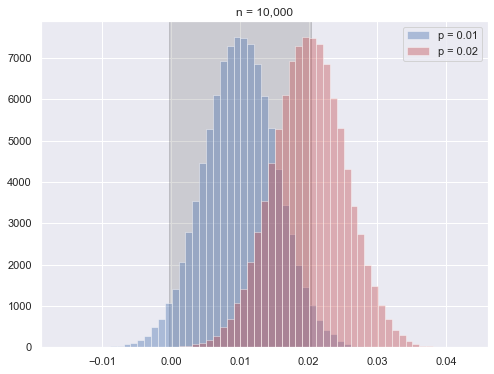

In [409]:
# visualise alpha for 10k users
fig, ax = plt.subplots(figsize = (8,6))

# simulate
n = 10000
pooled_0, pooled_d = getHypothesisDistributions(control_p, treat_p, n)

# plot 95% confidence interval
lower, upper = np.percentile(pooled_0, [2.5, 97.5])
ax.axvspan(lower, upper, color = 'k', alpha = 0.15)

# plot for n = 10k
plotHist(ax, pooled_0, pooled_d, n, binw = 0.001)

plt.show()

> We've just visualised $alpha$, the area of the blue peak outside the shaded box; this is our 5% allowed Type-1 rrror-rate.

In [387]:
# visualise beta for 10k users

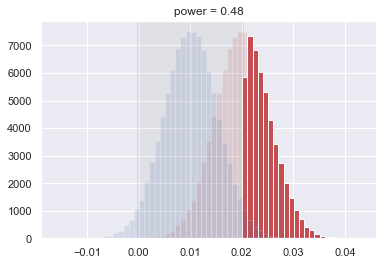

In [414]:
# plot 95% confidence interval
lower, upper = np.percentile(pooled_0, [2.5, 97.5])
plt.axvspan(lower, upper, color = 'k', alpha = 0.05)

arr2 = pooled_d
plt.hist(arr2, bins = np.arange(arr2.min(), arr2.max(), 0.001), color = 'r', alpha = 0.15, label = 'p = {:.2f}'.format(arr2.mean()));
plt.hist(arr2[arr2>upper], bins = np.arange(arr2.min(), arr2.max(), 0.001), color = 'r', alpha = 1, label = 'p = {:.2f}'.format(arr2.mean()));

arr1 = pooled_0
plt.hist(arr1, bins = np.arange(arr1.min(), arr1.max(), 0.001), color = 'b', alpha = 0.15, label = 'p = {:.2f}'.format(arr1.mean()));

plt.title('power = {:.2f}'.format(np.mean(arr2>upper)));

### 3. How many users do I need?
***

In [415]:
# distribution metrics
p_control = 0.16 
p_treatment = 0.17

# experiment parameters
alpha = 0.05
power = 0.8

# estimated
delta = p_treatment - p_control

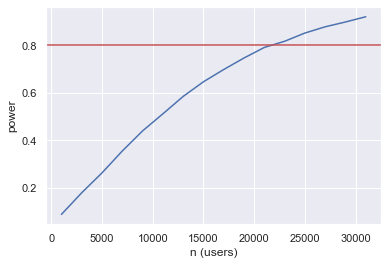

In [424]:
# our user-options
n_arr = np.arange(1000, 32000, 2000)
power = {}

for n in n_arr:
    pooled_0, pooled_d = getHypothesisDistributions(control_p, treat_p, n)
    
    # alpa confidence range
    lower, upper = np.percentile(pooled_0, [(alpha/2)*100, (1 - alpha/2) * 100])
    
    power[n] = np.mean(pooled_d>upper)

# visualise
plt.plot(list(power.keys()), list(power.values()))
plt.axhline(0.8, c='r')
plt.xlabel('n (users)')
plt.ylabel('power')
plt.show()

> Interesting! We see that we cross our power threshold just above 20,000 users. Let's zoom in on this area!

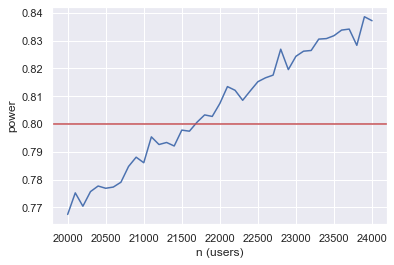

In [427]:
# our user-options
n_arr = np.arange(20000, 24100, 100)
power = {}

for n in n_arr:
    pooled_0, pooled_d = getHypothesisDistributions(control_p, treat_p, n)
    
    # alpa confidence range
    lower, upper = np.percentile(pooled_0, [(alpha/2)*100, (1 - alpha/2) * 100])
    
    power[n] = np.mean(pooled_d>upper)

# visualise
plt.plot(list(power.keys()), list(power.values()))
plt.axhline(0.8, c='r')
plt.xlabel('n (users)')
plt.ylabel('power')
plt.show()

In [436]:
power_df = pd.DataFrame.from_dict(power, orient = 'index', columns = ['power'])
power_df[power_df['power']>0.8].head()

,power
21700,0.80067
21800,0.80330
21900,0.80275
22000,0.80741
22100,0.81348


> Conclusion: we need at least 21,700 users per group (control and treatment) to get significance given our current conversion rate or 0.16, our desired increase of 0.01 for experiment parameters of $\alpha=0.05$ and a power of 0.8.

### 5. Getting these results with Statsmodels
***
Source: https://productds.com/wp-content/uploads/Sample_size.html

Alternative: https://www.evanmiller.org/ab-testing/sample-size.html

In [437]:
import statsmodels.stats.api as sm

In [438]:
# distribution metrics
p_control = 0.16 
p_treatment = 0.17

# experiment parameters
alpha = 0.05
power = 0.8

# estimated
p1_and_p2 = sm.proportion_effectsize(p_control, p_treatment)
sample_size = sm.NormalIndPower().solve_power(p1_and_p2, power=power, alpha=alpha)
sample_size

21623.029233846337

> We get the same results we got for our own power analysis!

#### Alternatively, we can also vary test conversion rate with sample size

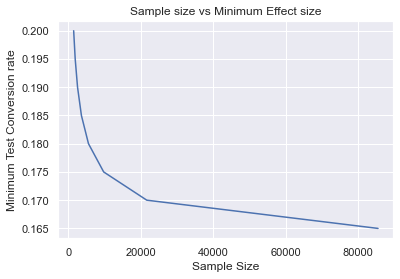

In [439]:
sample_size = []

#Possible p2 values. We choose from 16.5% to 20.5% with 0.5% increments
possible_p2 = np.arange(0.165, 0.205, .005)

#now let's estimate sample size for all those values and plot them
for i in possible_p2:
    p1_and_p2 = sm.proportion_effectsize(0.16, i)
    sample_size.append(sm.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))

plt.plot(sample_size, possible_p2)
plt.title("Sample size vs Minimum Effect size")
plt.xlabel("Sample Size")
plt.ylabel("Minimum Test Conversion rate")
plt.show()

#### INTERMEZZO: Binomial Standard Dev
***
The std. for a binomiual distribution is denoted by: $\sqrt{\frac{p(1-p)}{N}}$, hence, it scales as:

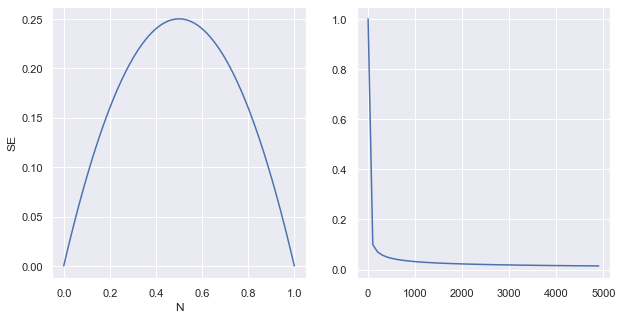

In [449]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
p = np.arange(0,1.01, 0.01)
S = p*(1-p)
ax[0].plot(p,S)
ax[0].set_xlabel('p')
ax[0].set_ylabel('SE')

N = np.arange(1,5000, 100)
S = 1/np.sqrt(N)
ax[1].plot(N,S)
ax[0].set_xlabel('N')
ax[0].set_ylabel('SE')

plt.show()

> We see that the standard deviation grows to a max around p=0.5 (grows with greater prob), and decreases with N.